# IMPORTS AND INSTALL

In [26]:
!pip install dicom2nifti

   ---------------------------------------- 0.0/28.9 MB ? eta -:--:--
   - -------------------------------------- 0.8/28.9 MB 8.5 MB/s eta 0:00:04
   ---- ----------------------------------- 3.4/28.9 MB 15.5 MB/s eta 0:00:02
   ------ --------------------------------- 4.7/28.9 MB 10.2 MB/s eta 0:00:03
   -------- ------------------------------- 6.0/28.9 MB 8.6 MB/s eta 0:00:03
   --------- ------------------------------ 7.1/28.9 MB 7.5 MB/s eta 0:00:03
   ----------- ---------------------------- 8.1/28.9 MB 7.1 MB/s eta 0:00:03
   ------------- -------------------------- 9.4/28.9 MB 7.2 MB/s eta 0:00:03
   -------------- ------------------------- 10.5/28.9 MB 6.7 MB/s eta 0:00:03
   --------------- ------------------------ 11.5/28.9 MB 6.5 MB/s eta 0:00:03
   ---------------- ----------------------- 12.1/28.9 MB 6.1 MB/s eta 0:00:03
   ----------------- ---------------------- 12.6/28.9 MB 5.9 MB/s eta 0:00:03
   ------------------ --------------------- 13.4/28.9 MB 5.6 MB/s eta 0:00:03

In [31]:
!pip install SimpleITK

In [1]:
!pip install --upgrade monai

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!pip install --upgrade ipykernel


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
import torch
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [7]:
!pip install --upgrade jupyter


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [29]:
from monai.transforms import Compose, LoadImageD, SpacingD,OrientationD,ResizeD,AsDiscreted,CropForegroundD
import os
from glob import glob
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,

)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

In [3]:
import importlib
libraries = ["torch", "torchvision", "torchaudio", "monai"]

# Check if each library is installed
for lib in libraries:
    spec = importlib.util.find_spec(lib)
    if spec is None:
        print(f"❌ {lib} is NOT installed!")
    else:
        try:
            module = importlib.import_module(lib)
            version = getattr(module, "__version__", "Unknown version")
            print(f"✅ {lib} is installed (Version: {version})")
        except Exception as e:
            print(f"⚠️ {lib} is installed but cannot be imported: {e}")


✅ torch is installed (Version: 2.5.1)
✅ torchvision is installed (Version: 0.20.1)
✅ torchaudio is installed (Version: 2.5.1)
✅ monai is installed (Version: 1.4.0)


# FIXING THE REQUIRED META DATA

In [70]:
import pydicom
import os
import glob

def fix_dicom_metadata(dicom_path):
    """Ensure all DICOM files have correct metadata before merging to NIfTI."""
    for dicom_file in glob.glob(os.path.join(dicom_path, "*.dcm")):
        ds = pydicom.dcmread(dicom_file)

        # Ensure InstanceNumber exists
        if not hasattr(ds, "InstanceNumber") or ds.InstanceNumber is None:
            ds.InstanceNumber = int(os.path.basename(dicom_file).split('_')[-1].split('.')[0])

        # Ensure essential metadata is present
        ds.SliceThickness = 1.0
        ds.PixelSpacing = [1.0, 1.0]
        ds.ImagePositionPatient = [0, 0, ds.InstanceNumber]
        ds.StudyInstanceUID = ds.StudyInstanceUID or pydicom.uid.generate_uid()
        ds.SeriesInstanceUID = ds.SeriesInstanceUID or pydicom.uid.generate_uid()
        ds.SOPInstanceUID = ds.SOPInstanceUID or pydicom.uid.generate_uid()

        # Save fixed file
        ds.save_as(dicom_file)

    print(f"✅ Fixed metadata for all DICOM files in {dicom_path}")


# SPLITTING THE DATA - TEST AND TRAIN

In [15]:
import os
import shutil
import random
from glob import glob

# Define paths
base_dir = r"D:\Task03_Liver\nifti_files"
image_dir = os.path.join(base_dir, "images")  # Source images
label_dir = os.path.join(base_dir, "labels")  # Source labels

# Define new folders
output_base = r"D:\Task03_Liver"
train_volumes = os.path.join(output_base, "TrainVolumes")
train_segmentation = os.path.join(output_base, "TrainSegmentation")
test_volumes = os.path.join(output_base, "TestVolumes")
test_segmentation = os.path.join(output_base, "TestSegmentation")

# Create folders if they don’t exist
for folder in [train_volumes, train_segmentation, test_volumes, test_segmentation]:
    os.makedirs(folder, exist_ok=True)

# Get all label files and ensure corresponding image files exist
label_files = sorted(glob(os.path.join(label_dir, "*.nii.gz")))
valid_label_files = [lbl for lbl in label_files if os.path.exists(os.path.join(image_dir, os.path.basename(lbl)))]

# Shuffle for randomness
random.shuffle(valid_label_files)

# 80-20 split
split_index = int(len(valid_label_files) * 0.2)
test_label_files = valid_label_files[:split_index]
train_label_files = valid_label_files[split_index:]

# Ensure corresponding image files are taken correctly
test_image_files = [os.path.join(image_dir, os.path.basename(lbl)) for lbl in test_label_files]
train_image_files = [os.path.join(image_dir, os.path.basename(lbl)) for lbl in train_label_files]

# Copy test data
for lbl, img in zip(test_label_files, test_image_files):
    shutil.copy(lbl, os.path.join(test_segmentation, os.path.basename(lbl)))
    shutil.copy(img, os.path.join(test_volumes, os.path.basename(img)))

# Copy train data
for lbl, img in zip(train_label_files, train_image_files):
    shutil.copy(lbl, os.path.join(train_segmentation, os.path.basename(lbl)))
    shutil.copy(img, os.path.join(train_volumes, os.path.basename(img)))

# Verify no duplicates exist between test and train
test_files = set(os.listdir(test_volumes))  # Files in test set
train_files = set(os.listdir(train_volumes))  # Files in train set

assert test_files.isdisjoint(train_files), "❌ ERROR: Duplicate files exist between train and test sets!"

# Print success message
print(f"✅ Dataset successfully split! Test: {len(test_label_files)}, Train: {len(train_label_files)}")
print("✅ No duplicate files exist between train and test sets.")


✅ Dataset successfully split! Test: 195, Train: 783
✅ No duplicate files exist between train and test sets.


# CHECKING THE VALIDITY OF FILES 

In [17]:
import os
import nibabel as nib
import pickle

def check_files_in_directory(directory):
    # List all files in the directory
    files = os.listdir(directory)
    
    # Iterate through each file in the directory
    for file in files:
        file_path = os.path.join(directory, file)

        # Check file extensions and perform corresponding validity checks
        if file.endswith('.nii.gz'):
            try:
                # Try loading the NIfTI file to check for corruption
                nib.load(file_path)
                print(f"Valid NIfTI file: {file_path}")
            except Exception as e:
                print(f"Corrupted NIfTI file: {file_path} - {e}")
        
        elif file.endswith('.pkl'):
            try:
                # Try loading the Pickle file to check for corruption
                with open(file_path, 'rb') as f:
                    pickle.load(f)
                print(f"Valid Pickle file: {file_path}")
            except Exception as e:
                print(f"Corrupted Pickle file: {file_path} - {e}")
        
        else:
            # If the file is not a .nii.gz or .pkl file, print the extension
            print(f"File with unsupported extension: {file_path}")

def check_directory_for_files(directories):
    # Iterate through each directory and check for files
    for directory in directories:
        print(f"Checking files in: {directory}")
        check_files_in_directory(directory)

# List of directories to check
directories = [
    "D:/Task03_Liver/Data_train_test/TrainVolumes",
    "D:/Task03_Liver/Data_train_test/TrainSegmentation",
    "D:/Task03_Liver/Data_train_test/TestVolumes",
    "D:/Task03_Liver/Data_train_test/TestSegmentation"
]

# Run the check
check_directory_for_files(directories)


Checking files in: D:/Task03_Liver/Data_train_test/TrainVolumes
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_0_0.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_0_1.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_0.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_1.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_10.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_2.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_3.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_4.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_5.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_6.nii.gz
Valid NIfTI file: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_7.nii.gz
Valid NIfTI file: D:/Task03_Liver/Dat

# SHAPE OF FILES 

In [21]:
import os
import nibabel as nib

# List of directories
directories = [
    "D:/Task03_Liver/Data_train_test/TrainVolumes",
    "D:/Task03_Liver/Data_train_test/TrainSegmentation",
    "D:/Task03_Liver/Data_train_test/TestVolumes",
    "D:/Task03_Liver/Data_train_test/TestSegmentation"
]

# Iterate over each directory
for dir_path in directories:
    print(f"\nProcessing directory: {dir_path}")

    # List all .nii.gz files in the directory
    nii_files = [f for f in os.listdir(dir_path) if f.endswith(".nii.gz")]

    if not nii_files:
        print("No .nii.gz files found in this directory.")
        continue

    # Load and print the shape of each .nii.gz file
    for file_name in nii_files:
        file_path = os.path.join(dir_path, file_name)
        
        try:
            img = nib.load(file_path)
            print(f"File: {file_name}, Shape: {img.shape}")
        except Exception as e:
            print(f"Error loading {file_name}: {e}")



Processing directory: D:/Task03_Liver/Data_train_test/TrainVolumes
File: liver_0_0.nii.gz, Shape: (512, 512, 64)
File: liver_0_1.nii.gz, Shape: (512, 512, 11)
File: liver_100_0.nii.gz, Shape: (512, 512, 64)
File: liver_100_1.nii.gz, Shape: (512, 512, 64)
File: liver_100_10.nii.gz, Shape: (512, 512, 45)
File: liver_100_2.nii.gz, Shape: (512, 512, 64)
File: liver_100_3.nii.gz, Shape: (512, 512, 64)
File: liver_100_4.nii.gz, Shape: (512, 512, 64)
File: liver_100_5.nii.gz, Shape: (512, 512, 64)
File: liver_100_6.nii.gz, Shape: (512, 512, 64)
File: liver_100_7.nii.gz, Shape: (512, 512, 64)
File: liver_100_8.nii.gz, Shape: (512, 512, 64)
File: liver_101_0.nii.gz, Shape: (512, 512, 64)
File: liver_101_1.nii.gz, Shape: (512, 512, 64)
File: liver_101_2.nii.gz, Shape: (512, 512, 64)
File: liver_101_3.nii.gz, Shape: (512, 512, 64)
File: liver_101_4.nii.gz, Shape: (512, 512, 64)
File: liver_101_5.nii.gz, Shape: (512, 512, 64)
File: liver_101_7.nii.gz, Shape: (512, 512, 64)
File: liver_101_8.nii.g

# REMOVING THE IMAGES AND LABELS IF Z<64 

In [25]:
import os
import nibabel as nib

# Define the folder pairs
folder_pairs = [
    ("D:/Task03_Liver/Data_train_test/TrainVolumes", "D:/Task03_Liver/Data_train_test/TrainSegmentation"),
    ("D:/Task03_Liver/Data_train_test/TestVolumes", "D:/Task03_Liver/Data_train_test/TestSegmentation")
]

# Process each pair
for vol_path, seg_path in folder_pairs:
    if not os.path.exists(vol_path) or not os.path.exists(seg_path):
        print(f"Path does not exist: {vol_path} or {seg_path}")
        continue

    for file in os.listdir(vol_path):
        if file.endswith(".nii.gz"):
            vol_file_path = os.path.join(vol_path, file)
            seg_file_path = os.path.join(seg_path, file)  # Corresponding segmentation file

            try:
                # Load the NIfTI file
                img = nib.load(vol_file_path)
                shape = img.shape  # (X, Y, Z)

                # If Z-dimension is less than 64, delete both volume and segmentation files
                if shape[2] < 64:
                    os.remove(vol_file_path)  # Delete volume file
                    if os.path.exists(seg_file_path):  # Delete segmentation file if it exists
                        os.remove(seg_file_path)
                        print(f"Deleted: {vol_file_path} and {seg_file_path} (Z={shape[2]})")
                    else:
                        print(f"Deleted: {vol_file_path} (Z={shape[2]}) - No segmentation found")
            except Exception as e:
                print(f"Error processing {vol_file_path}: {e}")

print("Processing complete.")


Deleted: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_0_1.nii.gz and D:/Task03_Liver/Data_train_test/TrainSegmentation\liver_0_1.nii.gz (Z=11)
Deleted: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_100_10.nii.gz and D:/Task03_Liver/Data_train_test/TrainSegmentation\liver_100_10.nii.gz (Z=45)
Deleted: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_102_10.nii.gz and D:/Task03_Liver/Data_train_test/TrainSegmentation\liver_102_10.nii.gz (Z=37)
Deleted: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_105_15.nii.gz and D:/Task03_Liver/Data_train_test/TrainSegmentation\liver_105_15.nii.gz (Z=26)
Deleted: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_108_13.nii.gz and D:/Task03_Liver/Data_train_test/TrainSegmentation\liver_108_13.nii.gz (Z=24)
Deleted: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_109_11.nii.gz and D:/Task03_Liver/Data_train_test/TrainSegmentation\liver_109_11.nii.gz (Z=52)
Deleted: D:/Task03_Liver/Data_train_test/TrainVolumes\liver_10_7.nii.gz and 

# Background Labels check

In [36]:
import os
import numpy as np
import nibabel as nib

# Define label folders
label_folders = [
    "D:/Task03_Liver/Data_train_test/TrainSegmentation",
    "D:/Task03_Liver/Data_train_test/TestSegmentation"
]

# Function to print unique labels in each file
def print_label_classes(label_folder):
    print(f"\nChecking labels in folder: {label_folder}")
    
    for filename in os.listdir(label_folder):
        label_path = os.path.join(label_folder, filename)

        # Check file format and load accordingly
        if filename.endswith(".npy"):
            label_data = np.load(label_path)
        elif filename.endswith(".nii") or filename.endswith(".nii.gz"):
            label_data = nib.load(label_path).get_fdata()
        else:
            print(f"Skipping unsupported file: {filename}")
            continue
        
        # Get unique classes in the label file
        unique_classes = np.unique(label_data)
        
        # Print results
        print(f"File: {filename} → Unique Classes: {unique_classes}")

# Iterate through label folders and check labels
for label_folder in label_folders:
    print_label_classes(label_folder)



Checking labels in folder: D:/Task03_Liver/Data_train_test/TrainSegmentation
File: liver_0_0.nii.gz → Unique Classes: [0. 1. 2.]
File: liver_100_0.nii.gz → Unique Classes: [0.]
File: liver_100_1.nii.gz → Unique Classes: [0.]
File: liver_100_2.nii.gz → Unique Classes: [0.]
File: liver_100_3.nii.gz → Unique Classes: [0.]
File: liver_100_4.nii.gz → Unique Classes: [0.]
File: liver_100_5.nii.gz → Unique Classes: [0.]
File: liver_100_6.nii.gz → Unique Classes: [0. 1. 2.]
File: liver_100_7.nii.gz → Unique Classes: [0. 1. 2.]
File: liver_100_8.nii.gz → Unique Classes: [0. 1. 2.]
File: liver_101_0.nii.gz → Unique Classes: [0.]
File: liver_101_1.nii.gz → Unique Classes: [0.]
File: liver_101_2.nii.gz → Unique Classes: [0.]
File: liver_101_3.nii.gz → Unique Classes: [0.]
File: liver_101_4.nii.gz → Unique Classes: [0.]
File: liver_101_5.nii.gz → Unique Classes: [0.]
File: liver_101_7.nii.gz → Unique Classes: [0. 1. 2.]
File: liver_101_8.nii.gz → Unique Classes: [0. 1. 2.]
File: liver_101_9.nii.gz

In [40]:
import os
import numpy as np
import nibabel as nib

# Define folder paths
train_label_folder = "D:/Task03_Liver/Data_train_test/TrainSegmentation"
test_label_folder = "D:/Task03_Liver/Data_train_test/TestSegmentation"
train_volume_folder = "D:/Task03_Liver/Data_train_test/TrainVolumes"
test_volume_folder = "D:/Task03_Liver/Data_train_test/TestVolumes"

# Function to count total and empty-label files
def count_files_and_empty_labels(label_folder):
    total_files = 0
    empty_label_files = 0

    for filename in os.listdir(label_folder):
        label_path = os.path.join(label_folder, filename)
        total_files += 1

        # Load label data
        if filename.endswith(".npy"):
            label_data = np.load(label_path)
        elif filename.endswith(".nii") or filename.endswith(".nii.gz"):
            label_data = nib.load(label_path).get_fdata()
        else:
            print(f"Skipping unsupported file: {filename}")
            continue
        
        # Check if the label contains only [0.]
        if np.array_equal(np.unique(label_data), [0.]):
            empty_label_files += 1

    return total_files, empty_label_files

# Get counts for train and test label sets
train_total_labels, train_empty_labels = count_files_and_empty_labels(train_label_folder)
test_total_labels, test_empty_labels = count_files_and_empty_labels(test_label_folder)

# Get original counts for volumes (assuming filenames match in both folders)
train_total_volumes = len(os.listdir(train_volume_folder))
test_total_volumes = len(os.listdir(test_volume_folder))

# Compute expected remaining files
train_remaining = train_total_labels - train_empty_labels
test_remaining = test_total_labels - test_empty_labels

# Print results
print(f"Original Training Labels: {train_total_labels}")
print(f"Original Testing Labels: {test_total_labels}")
print(f"Training Labels with only [0.]: {train_empty_labels}")
print(f"Testing Labels with only [0.]: {test_empty_labels}")

print(f"\nOriginal Training Volumes: {train_total_volumes}")
print(f"Original Testing Volumes: {test_total_volumes}")

print(f"\nExpected Remaining Training Labels: {train_remaining}")
print(f"Expected Remaining Testing Labels: {test_remaining}")
print(f"Expected Remaining Training Volumes: {train_remaining}")
print(f"Expected Remaining Testing Volumes: {test_remaining}")


Original Training Labels: 688
Original Testing Labels: 166
Training Labels with only [0.]: 383
Testing Labels with only [0.]: 102

Original Training Volumes: 688
Original Testing Volumes: 166

Expected Remaining Training Labels: 305
Expected Remaining Testing Labels: 64
Expected Remaining Training Volumes: 305
Expected Remaining Testing Volumes: 64


In [42]:
import os
import numpy as np
import nibabel as nib

# Define folder paths
train_label_folder = "D:/Task03_Liver/Data_train_test/TrainSegmentation"
test_label_folder = "D:/Task03_Liver/Data_train_test/TestSegmentation"
train_volume_folder = "D:/Task03_Liver/Data_train_test/TrainVolumes"
test_volume_folder = "D:/Task03_Liver/Data_train_test/TestVolumes"

# Function to delete empty label files and their corresponding images
def delete_empty_labels_and_images(label_folder, volume_folder):
    deleted_count = 0

    for filename in os.listdir(label_folder):
        label_path = os.path.join(label_folder, filename)
        volume_path = os.path.join(volume_folder, filename)  # Assuming filenames match

        # Load label data
        if filename.endswith(".npy"):
            label_data = np.load(label_path)
        elif filename.endswith(".nii") or filename.endswith(".nii.gz"):
            label_data = nib.load(label_path).get_fdata()
        else:
            print(f"Skipping unsupported file: {filename}")
            continue
        
        # Check if the label contains only [0.]
        if np.array_equal(np.unique(label_data), [0.]):
            os.remove(label_path)  # Delete label
            if os.path.exists(volume_path):
                os.remove(volume_path)  # Delete corresponding image
            print(f"Deleted: {filename}")
            deleted_count += 1

    return deleted_count

# Perform deletion for train and test sets
train_deleted = delete_empty_labels_and_images(train_label_folder, train_volume_folder)
test_deleted = delete_empty_labels_and_images(test_label_folder, test_volume_folder)

# Print results
print(f"\nDeleted {train_deleted} training label-image pairs.")
print(f"Deleted {test_deleted} testing label-image pairs.")
print("\nCleanup complete! 🚀")


Deleted: liver_100_0.nii.gz
Deleted: liver_100_1.nii.gz
Deleted: liver_100_2.nii.gz
Deleted: liver_100_3.nii.gz
Deleted: liver_100_4.nii.gz
Deleted: liver_100_5.nii.gz
Deleted: liver_101_0.nii.gz
Deleted: liver_101_1.nii.gz
Deleted: liver_101_2.nii.gz
Deleted: liver_101_3.nii.gz
Deleted: liver_101_4.nii.gz
Deleted: liver_101_5.nii.gz
Deleted: liver_102_1.nii.gz
Deleted: liver_102_2.nii.gz
Deleted: liver_102_3.nii.gz
Deleted: liver_102_4.nii.gz
Deleted: liver_103_0.nii.gz
Deleted: liver_103_1.nii.gz
Deleted: liver_103_2.nii.gz
Deleted: liver_103_3.nii.gz
Deleted: liver_103_4.nii.gz
Deleted: liver_104_0.nii.gz
Deleted: liver_104_1.nii.gz
Deleted: liver_104_2.nii.gz
Deleted: liver_104_3.nii.gz
Deleted: liver_104_8.nii.gz
Deleted: liver_104_9.nii.gz
Deleted: liver_105_0.nii.gz
Deleted: liver_105_1.nii.gz
Deleted: liver_105_10.nii.gz
Deleted: liver_105_11.nii.gz
Deleted: liver_105_12.nii.gz
Deleted: liver_105_13.nii.gz
Deleted: liver_105_14.nii.gz
Deleted: liver_105_2.nii.gz
Deleted: liver_

# ORIGINAL IMAGE AND ITS LABEL

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from monai.transforms import LoadImage

# Set dataset directory
data_dir = "D:/Task03_Liver/Data_train_test"

# Load one sample from TrainVolumes and TrainSegmentation
volume_path = sorted(glob.glob(os.path.join(data_dir, "TrainVolumes", "*.nii.gz")))[0]  # First volume
label_path = sorted(glob.glob(os.path.join(data_dir, "TrainSegmentation", "*.nii.gz")))[0]  # First label

# Load the .nii.gz files using MONAI's LoadImage transform
load_image = LoadImage(image_only=True)
volume = load_image(volume_path)  # Shape: (Depth, Height, Width)
label = load_image(label_path)  # Shape: (Depth, Height, Width)

# Convert to numpy for visualization
vol_data = volume.numpy()
seg_data = label.numpy()

def show_patient(slice_number):
    """
    Displays the test volume and corresponding segmentation for a given slice.
    
    Args:
        slice_number (int): The slice index to visualize.
    
    Raises:
        ValueError: If the slice_number is out of bounds.
    """
    max_slice = vol_data.shape[2] - 1

    if slice_number > max_slice or slice_number < 0:
        raise ValueError(f"SLICE_NUMBER {slice_number} out of bounds! Max available slice: {max_slice}")

    # Plot volume and corresponding label with square shape
    plt.figure("Visualization Test", (12, 6))

    plt.subplot(1, 2, 1)
    plt.title(f"Test Volume {slice_number}")
    plt.imshow(vol_data[:, :, slice_number], cmap="gray", aspect="auto")

    plt.subplot(1, 2, 2)
    plt.title(f"Test Segmentation {slice_number}")
    plt.imshow(seg_data[:, :, slice_number], cmap="gray", aspect="auto")

    plt.show()



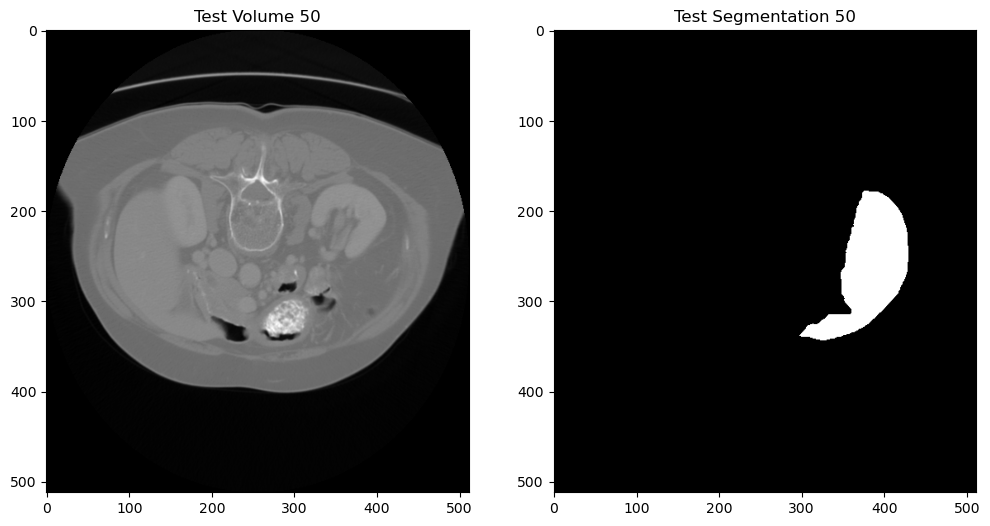

In [3]:
show_patient(50)

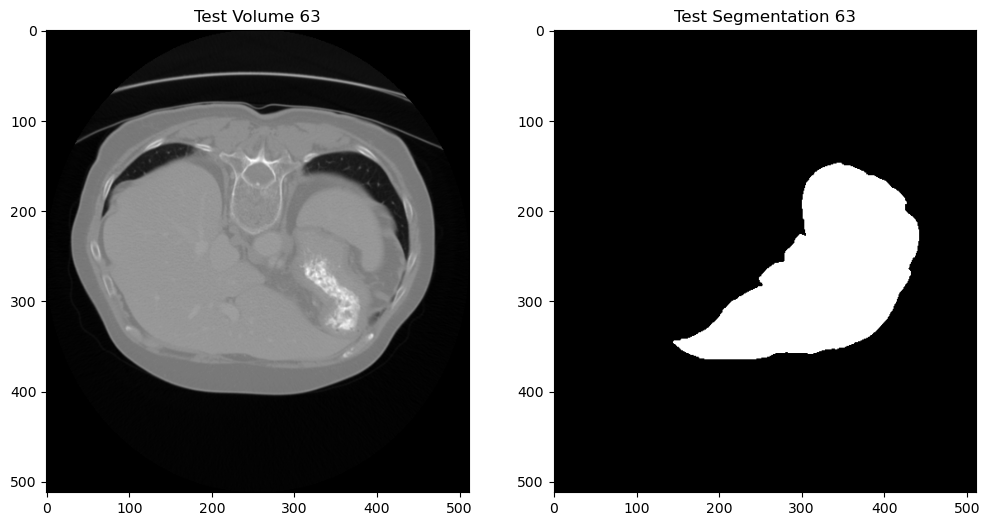

In [48]:
show_patient(63)

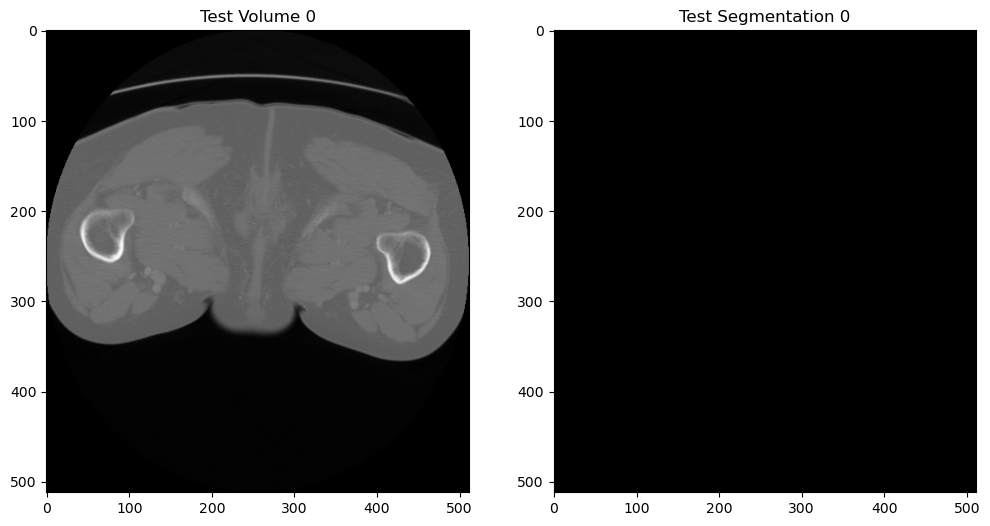

In [50]:
show_patient(0)

# TRAINING THE MODEL

In [36]:
pip install --upgrade monai


In [1]:
import torch
from monai.utils import first
from monai.losses import DiceLoss, DiceCELoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm


In [31]:
import nibabel as nib
import numpy as np
import glob

data_dir = 'D:/Task03_Liver/Data_train_test'
train_seg_paths = glob.glob(f"{data_dir}/TrainSegmentation/*.nii.gz")

# Check number of unique labels in segmentation files
unique_labels = set()
for seg_path in train_seg_paths[:5]:  # Check first 5 files
    seg_data = nib.load(seg_path).get_fdata()
    unique_labels.update(np.unique(seg_data))

print("Unique Labels in Dataset:", unique_labels)
print("Number of Classes:", len(unique_labels))


Unique Labels in Dataset: {0.0, 1.0, 2.0}
Number of Classes: 3


In [1]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # For user warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # For future warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # For deprecation warnings


In [3]:
import os
import glob
import torch
import numpy as np
from tqdm import tqdm
from monai.losses import DiceLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityRanged,
    CropForegroundd, Resized, ToTensord
)
import torch.nn.functional as F 

In [95]:
import os
import numpy as np
import random
import nibabel as nib

# Define paths to your data folders
train_images_path = "D:/Task03_Liver/Data_train_test/TrainVolumes"
train_labels_path = "D:/Task03_Liver/Data_train_test/TrainSegmentation"
test_images_path = "D:/Task03_Liver/Data_train_test/TestVolumes"
test_labels_path = "D:/Task03_Liver/Data_train_test/TestSegmentation"

# Get all filenames in the train set (assuming corresponding names for images and labels)
image_files = sorted(os.listdir(train_images_path))
label_files = sorted(os.listdir(train_labels_path))

# Ensure we have matching pairs
assert len(image_files) == len(label_files), "Mismatch in number of images and labels"

# Select 5 random samples
num_samples = 5
random_indices = random.sample(range(len(image_files)), num_samples)

# Function to load a NIfTI image
def load_nifti(path):
    return nib.load(path).get_fdata()

# Check shapes and unique values
for i, idx in enumerate(random_indices):
    image_path = os.path.join(train_images_path, image_files[idx])
    label_path = os.path.join(train_labels_path, label_files[idx])

    image = load_nifti(image_path)
    label = load_nifti(label_path)

    print(f"Sample {i + 1}:")
    print(f"  Image Shape: {image.shape}, Unique Values: {np.unique(image)}")
    print(f"  Label Shape: {label.shape}, Unique Values: {np.unique(label)}")
    print("-" * 50)


Sample 1:
  Image Shape: (512, 512, 64), Unique Values: [0.0000e+00 2.4000e+01 2.7000e+01 ... 6.5503e+04 6.5504e+04 6.5535e+04]
  Label Shape: (512, 512, 64), Unique Values: [0. 1.]
--------------------------------------------------
Sample 2:
  Image Shape: (512, 512, 64), Unique Values: [0.0000e+00 2.7000e+01 2.8000e+01 ... 6.5470e+04 6.5505e+04 6.5535e+04]
  Label Shape: (512, 512, 64), Unique Values: [0. 1.]
--------------------------------------------------
Sample 3:
  Image Shape: (512, 512, 64), Unique Values: [0.0000e+00 2.6000e+01 2.7000e+01 ... 6.5506e+04 6.5507e+04 6.5535e+04]
  Label Shape: (512, 512, 64), Unique Values: [0. 1.]
--------------------------------------------------
Sample 4:
  Image Shape: (512, 512, 64), Unique Values: [0.0000e+00 1.8000e+01 2.0000e+01 ... 6.5504e+04 6.5505e+04 6.5535e+04]
  Label Shape: (512, 512, 64), Unique Values: [0. 1.]
--------------------------------------------------
Sample 5:
  Image Shape: (512, 512, 64), Unique Values: [0.0000e+00 

In [83]:
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm  # For progress bar

# Paths to label directories
train_labels_path = "D:/Task03_Liver/Data_train_test/TrainSegmentation"
test_labels_path = "D:/Task03_Liver/Data_train_test/TestSegmentation"

# Function to process labels and save them back
def process_labels(label_dir):
    label_files = sorted(os.listdir(label_dir))

    for label_file in tqdm(label_files, desc=f"Processing {label_dir}"):
        label_path = os.path.join(label_dir, label_file)

        # Load label
        label_nifti = nib.load(label_path)
        label_data = label_nifti.get_fdata()

        # Convert all 2s to 1 (binary segmentation)
        label_data[label_data == 2] = 1

        # Save the corrected label
        new_nifti = nib.Nifti1Image(label_data, affine=label_nifti.affine, header=label_nifti.header)
        nib.save(new_nifti, label_path)

# Process training and testing labels
process_labels(train_labels_path)
process_labels(test_labels_path)

print("✅ All label files are now correctly binary (0 or 1)!")


Processing D:/Task03_Liver/Data_train_test/TrainSegmentation: 100%|██████████████████| 305/305 [06:33<00:00,  1.29s/it]
Processing D:/Task03_Liver/Data_train_test/TestSegmentation: 100%|█████████████████████| 64/64 [01:17<00:00,  1.20s/it]

✅ All label files are now correctly binary (0 or 1)!
